# Agent con Feedback con LangGraph

## Definición (nivel MIT/Stanford, aplicada)
Agent con feedback combina tools, razonamiento iterativo y evaluación de salida. Si no aprueba, regresa al agente con feedback concreto.

## Cuándo usarla
Úsalo cuando necesitas autonomía controlada: herramientas + calidad auditada.

## Cuándo NO usarla
Evítalo si no hay tools reales ni criterio de evaluación; sería complejidad vacía.

## Diagrama Conceptual

```mermaid
graph TD
A[Agent] --> B{Tool call?}
B -->|yes| C[Tools]
C --> A
B -->|no| D[Evaluate]
D -->|approved| E[End]
D -->|improve| A
```

In [1]:
# Setup de clase
from __future__ import annotations

import importlib.util
import inspect
import json
import sys
from pathlib import Path
from IPython.display import Image, Markdown, display


def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("No se encontro raiz del repo")


def load_module(path: Path, module_name: str):
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    if spec is None or spec.loader is None:
        raise RuntimeError(f"No se pudo cargar modulo: {path}")
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

ROOT = find_repo_root(Path.cwd())
print(f"Repo root: {ROOT}")

Repo root: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry


In [2]:
script_path = ROOT / '04_langchain_langgraph/06_agent_feedback/Notebooks/01_agent_feedback_langgraph.py'
module = load_module(script_path, 'nb_agent_fb')
run_fn = module.run_agent_feedback
print('Script:', script_path)
print('Función:', run_fn.__name__)

Script: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/04_langchain_langgraph/06_agent_feedback/Notebooks/01_agent_feedback_langgraph.py
Función: run_agent_feedback


## Código de la arquitectura (visible en notebook)

In [3]:
print(inspect.getsource(run_fn)[:5000])

def run_agent_feedback(profile: dict | None = None, verbose: bool = True) -> dict:
    root = find_repo_root(Path.cwd())
    load_dotenv(root / ".env")
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY no esta definida en .env")

    model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    llm = ChatOpenAI(model=model, temperature=0.4, api_key=api_key)
    evaluator_llm = ChatOpenAI(model=model, temperature=0.1, api_key=api_key)

    build_context_packet = load_context_builder(root)
    if profile is None:
        profile = {
            "tipo_persona": "fundador de startup de robotica educativa",
            "gustos": ["ajedrez", "cafes de especialidad", "senderismo de montana"],
            "estilo": "analitico, curioso, humor sobrio",
            "contexto": "primer mensaje luego de un match mutuo",
        }
    context_packet = build_context_packet(profile=profile, architecture="agent_feedback")

    @tool
    def profile_signal_l

## Ejemplo 1: caso base del curso

In [4]:
result_1 = run_fn(verbose=False)
print('Modelo:', result_1['__model'])
print('Context hash:', result_1['__context_hash'])

Modelo: gpt-4o-mini
Context hash: eb366219cea6


In [5]:
print('Approved:', result_1['approved'])
print('Feedback rounds:', result_1['feedback_rounds'])
print('Evaluator note:', result_1['evaluator_note'])
print('Respuesta final:')
print(result_1['final_response'])

Approved: True
Feedback rounds: 0
Evaluator note: La respuesta es adecuada y personalizada, mencionando dos gustos relevantes del perfil. Se respeta el contexto y no hay manipulación ni presión. Sin embargo, podría ser más atractiva si incluyera un toque de humor sobrio, acorde al estilo del perfil.
Respuesta final:
OPENER: ¡Hola! Vi que te gusta el ajedrez. ¿Cuál es tu apertura favorita? | FOLLOW_UP: También me encanta explorar cafés de especialidad. ¿Tienes algún lugar en mente que recomiendes?


## Grafo real LangGraph (comportamiento)

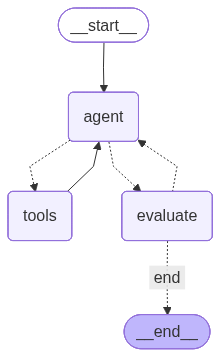

In [6]:
agent = result_1['__agent']
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as exc:
    print('No se pudo renderizar PNG en este entorno:', exc)
    display(Markdown('```mermaid\n' + result_1['__graph_mermaid'] + '\n```'))

## Ejemplo 2: asistente latino experto en enamorar (coqueteo creativo y respetuoso)

In [7]:
profile_coqueteo = {
  "tipo_persona": "asistente latino experto en enamorar con elegancia",
  "gustos": [
    "salsa romantica",
    "cafes bohemios",
    "poesia urbana",
    "paseos nocturnos"
  ],
  "estilo": "carismatico, coqueto, respetuoso, humor picante sutil",
  "contexto": "quiere iniciar una conversacion de coqueteo sin caer en frases prefabricadas"
}
result_2 = run_fn(profile=profile_coqueteo, verbose=False)
print('Context hash coqueteo:', result_2['__context_hash'])
print('Perfil coqueteo:')
print(json.dumps(profile_coqueteo, ensure_ascii=False, indent=2))

Context hash coqueteo: 513d7b619245
Perfil coqueteo:
{
  "tipo_persona": "asistente latino experto en enamorar con elegancia",
  "gustos": [
    "salsa romantica",
    "cafes bohemios",
    "poesia urbana",
    "paseos nocturnos"
  ],
  "estilo": "carismatico, coqueto, respetuoso, humor picante sutil",
  "contexto": "quiere iniciar una conversacion de coqueteo sin caer en frases prefabricadas"
}


In [8]:
print('Approved:', result_2['approved'])
print('Feedback rounds:', result_2['feedback_rounds'])
print('Evaluator note:', result_2['evaluator_note'])
print('Respuesta coqueteo:')
print(result_2['final_response'])

Approved: True
Feedback rounds: 0
Evaluator note: La respuesta es bastante buena, ya que personaliza la conversación al referirse a gustos específicos como la salsa romántica y los cafés bohemios. Muestra respeto al no ser manipulativa ni explícita, y es accionable al proponer un encuentro en un ambiente agradable. Sin embargo, podría mejorar al incluir un toque más de humor picante sutil para alinearse mejor con el estilo del perfil.
Respuesta coqueteo:
OPENER: "Si tuvieras que elegir una canción de salsa romántica que te haga sonreír cada vez que la escuchas, ¿cuál sería y por qué?" | FOLLOW_UP: "¿Te gustaría compartir un café bohemio en un lugar con buena música? Me encantaría saber qué tipo de ambiente te inspira más."


## Errores típicos en producción
- Elegir esta arquitectura por moda y no por necesidad.
- No definir métricas de calidad/costo/latencia antes de escalar.
- No versionar contexto ni criterios de evaluación.
- Falta de observabilidad para diagnosticar degradaciones.

## Lectura crítica del resultado
- Evalúa si el flujo realmente mejoró calidad o solo añadió complejidad.
- Compara latencia/costo vs beneficio de control arquitectónico.
- Decide si esta arquitectura es mínima suficiente para tu caso real.